### Mounting your google drive on Colab Noetebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
## remplazá 'workshopml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/workshopml/ML_workshop2020/  
datapath = './data/clinvarHC_modeling.csv.gz'
targetname = 'ClinvarHC'

/content/drive/My Drive/workshopml/ML_workshop2020


In [2]:
%matplotlib inline

# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from IPython.display import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load and split data

In [3]:
SEED = 2718281
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt')
X,y = data.drop([targetname],axis = 1), data[[targetname]]

## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)


### Preprocessing

In [4]:
categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)] # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])


### Qué quiero ver: 

* Optimización de hyperparámetros : gridsearch

* Convencernos que L1 mata features correlacionados y L2 distribuye los pesos

* Recursive feature elimination

* Utilizando L1 (que tiende a matar features correlacionados): sparsity 

* Nro features (y cuáles) en términos de C. 




## Model

In [13]:
### Construimos el Pipeline
## Regresion Logistica 
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  
#especificamos el solver para evitar warnings


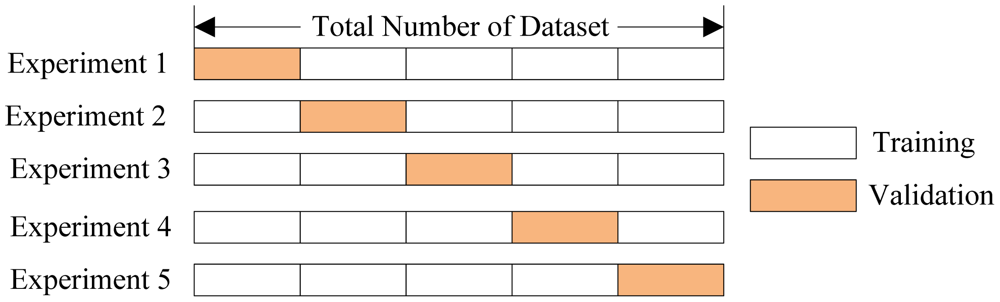

In [ ]:
Image(filename = "./CrossValid.png", width=600, height=600)

In [15]:
#lr_C =  [0.1,1,10]
lr_C =  [0.0001,0.001,0.01,0.1,1,10,100,1000]

param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1']}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, y_train[targetname].ravel())


pipeline = search.best_estimator_  ## Nuestro pipeline se usó localmente. Con esta línea le paso la configuración óptima de la búsqueda
############
# y si usamos average_precision?
#search = GridSearchCV(pipeline, param_grid, 
#                      cv=2,return_train_score = True,
#                     scoring = 'average_precision').fit(X_train, y_train.ClinvarHC.ravel())

* GridSearchCV No retiene explícitamente los modelos generados (i.e. , sus coeficientes) en cada combinación de parámetros de la grilla de búsqueda. 



* Sólo retiene los scores de cada modelo generado, y los parámetros del modelo de "mejor performance" acorde al criterio por default (maximizar el score medio en el evaluation set)



### Cómo le va en performance?

Text(0.5, 0, 'regularization parameter')

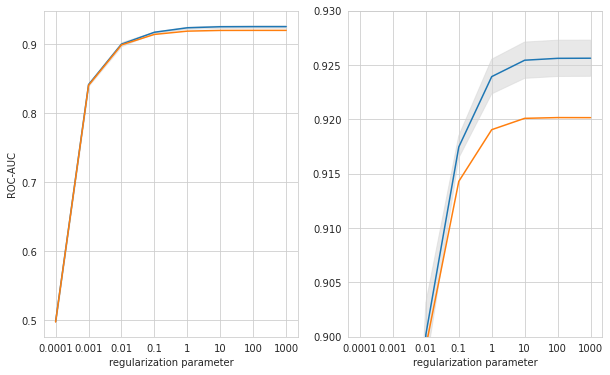

In [16]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])

ax2.set_xlabel('regularization parameter')



### Fijensé que para valores de C ariba de 0.1, ya el modelo empieza a sobreajustar.
* No obstante, hasta C =1 (ó 10?) parece tener sentido porque sigue levantando la performance en el set de evaluación. 


In [ ]:
numerical_names = pipeline.named_steps['preprocessing'].transformers[0][2].tolist()
categorical_output_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names  # ver nota abajo

search.best_estimator_['clasificador']

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### C= 100?? Es necesario? Qué implicancia tiene en el modelo?


Veamos: 
* De 0.1 a 1 se tocan los Intervalos de confianza en el traning?
## Rta:  NO

* De 1 a 10?
## Rta:  Sí. Entonces ahí no tengo ganancia significativa

Por inspección (se puede cuantificar vía DeLong test o Bostraping), si tengo que elegir sólo mirando ésto freno en
  ##  C= 1. 





###########################################################################
### Entreno modelos para cada valor de C (sin CV, usando todo el train):
###########################################################################


* Esto nos va a permitir analizar los coeficientes de cada modelo, en particular cuantas variable 'mató' (tiró a cero).

In [65]:
sparsity_l1_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l1'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train[targetname].ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l1_LR.update({Id: sparc})

sparsity = pd.Series(sparsity_l1_LR)

0.0001
0.001
0.01
0.1
1
10
100
1000


Notar que a menor penalización, más tarda en converger. 

Text(0, 0.5, 'regularization parameter')

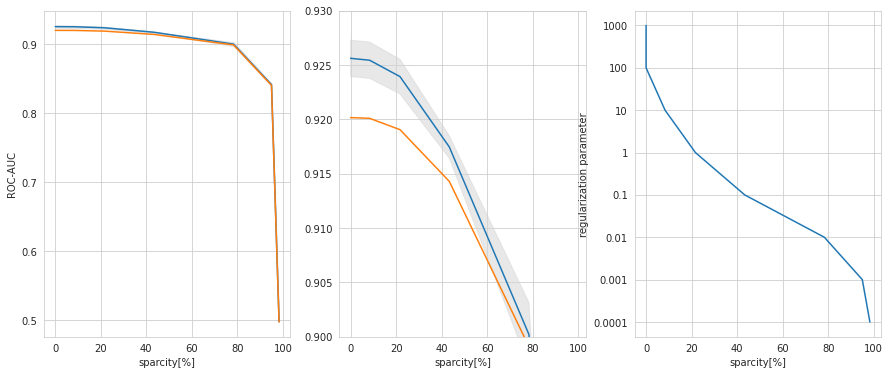

In [66]:
matplotlib.rcParams['figure.figsize'] = [15, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(sparsity, performance.mean_train_score)
ax1.plot(sparsity, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(sparsity, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('sparcity[%]')


ax2.plot(sparsity, performance.mean_train_score)
ax2.plot(sparsity, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(sparsity, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])
ax2.set_xlabel('sparcity[%]')

ax3.plot(sparsity,performance.C)
ax3.set_xlabel('sparcity[%]')
ax3.set_ylabel('regularization parameter')




### A mayor penalización modelo más simple
* mayor penalización, (menor C), el modelo penaliza más coeficientes (los lleva a cero)
* Vemos que el C = 1 que analizé anteriormente, corresponde a un sparcity del 20%, osea a usar el 80% de los features. 
 (~0.918 en el evaluation) el training está sobreajustando un poco. 
 
* La diferencia que tenemos por incorporar más features llega a tope en 0.92. Es estadísticamente significativa esa diferencia?

In [128]:
import rpy2 as r2p
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


pROC = importr('pROC')
ro.r('''
roctest<- function(y,pred1,pred2){
  rroc1 = roc(y,pred1)
  rroc2 = roc(y,pred2)
  signif <- pROC::roc.test(rroc1,rroc2)
  return(signif)
}
''')
roctest = ro.globalenv['roctest']


In [188]:
#irnd = np.random.choice(X_train.shape[0], 50)
m001 = model['0.01'].predict_proba(X_train)
m01 = model['0.1'].predict_proba(X_train)
m10 = model['10'].predict_proba(X_train)
m1 = model['10'].predict_proba(X_train)
m100 = model['100'].predict_proba(X_train)

#roc1 = pROC.roc(y_train[targetname].values,m01[:,1])
#roc2 = pROC.roc(y_train[targetname].values,m100[:,1])
#signif = roctest(roc1,roc2)
#signif.rx('p.value')[0]

## Hay diferencias significatias en los resultados obtenidos con C= 0.1 y C = 1 ? 

* Sí (pero ojo que esta cuenta está sobreestimada, entreno y predigo en el train)




In [193]:
signif = roctest(y_train[targetname].values,m01[:,1],m1[:,1])
pv = signif.rx('p.value')[0]
print(pv)

[1] 7.629821e-20



## En cambio, entre C = 1 y C = 10 ya no hay ganancia significativa ni aún sobreajustando. 

In [194]:
signif = roctest(y_train[targetname].values,m1[:,1],m10[:,1])
pv = signif.rx('p.value')[0]
print(pv)

[1] 1



### En el testing también da significativo (un poco menos, tiene sentido)
## Qué está mal de hacerlo así? 
## Cómo es la forma correcta?

In [195]:
t01 = model['0.1'].predict_proba(X_test)
t1 = model['1'].predict_proba(X_test)
signif = roctest(y_test[targetname].values,t01[:,1],t1[:,1])
pv = signif.rx('p.value')[0]
print(pv)

[1] 2.88983e-18



##  Exploremos algunos features


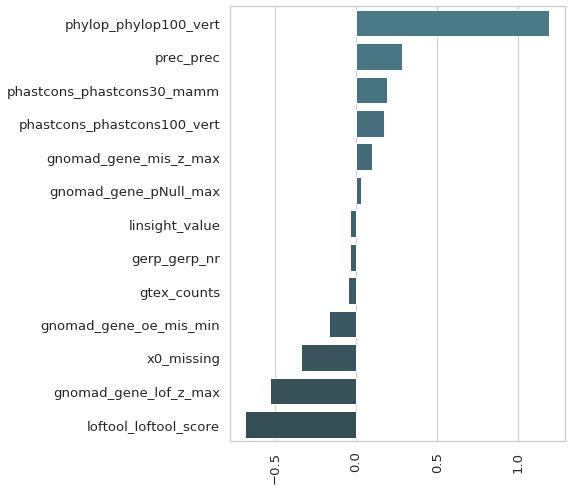

In [ ]:
matplotlib.rcParams['figure.figsize'] = [6,8]
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
coefs = pd.Series(model['0.01']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

### Por qué fui a C = 0.01? Lo hice para meter una penalización bien dura y "mirar" los features que sobreviven. 

# No me parece menor la observacion de que, sobrevivieron features de distinta naturaleza: 
*  Conservación (phylop, phascons)
*  Scores de haploinsuficiencia (gnomad oe_lof)
*  Expresión en tejidos (gtex_counts)
*  Interpro domains (X0_missing). Osea, que la variante caiga fuera de un dominio estructural es informativo

# Cuál es la performance del modelo?

In [ ]:
ypred_test = model['1'].predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,ypred_test)

0.9244570385825382

### Que pasa si usamos L2?
* Sparsity? 
* Performance?
* Redundancia? Robustez?

In [197]:

pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  

lr_C =  [0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid = [ {'clasificador__C':lr_C, 'clasificador__penalty': ['l2']} ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, y_train.ClinvarHC.ravel())

##### Recompute models

sparsity_l2_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l2'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train.ClinvarHC.ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l2_LR.update({Id: sparc})

    
sparsity = pd.Series(sparsity_l2_LR)

0.0001
0.001
0.01
0.1
1
10
100
1000


Text(0.5, 0, 'regularization parameter')

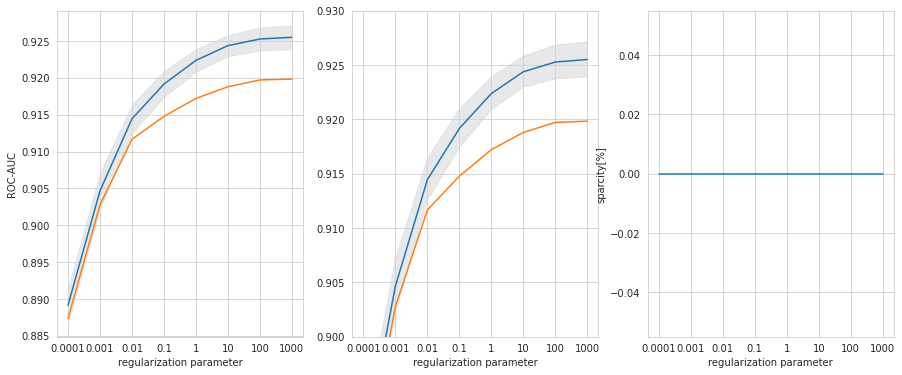

In [198]:

matplotlib.rcParams['figure.figsize'] = [15,6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score


ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)
ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])
ax2.set_xlabel('regularization parameter')

ax3.plot(performance.C,sparsity)
ax3.set_ylabel('sparcity[%]')
ax3.set_xlabel('regularization parameter')

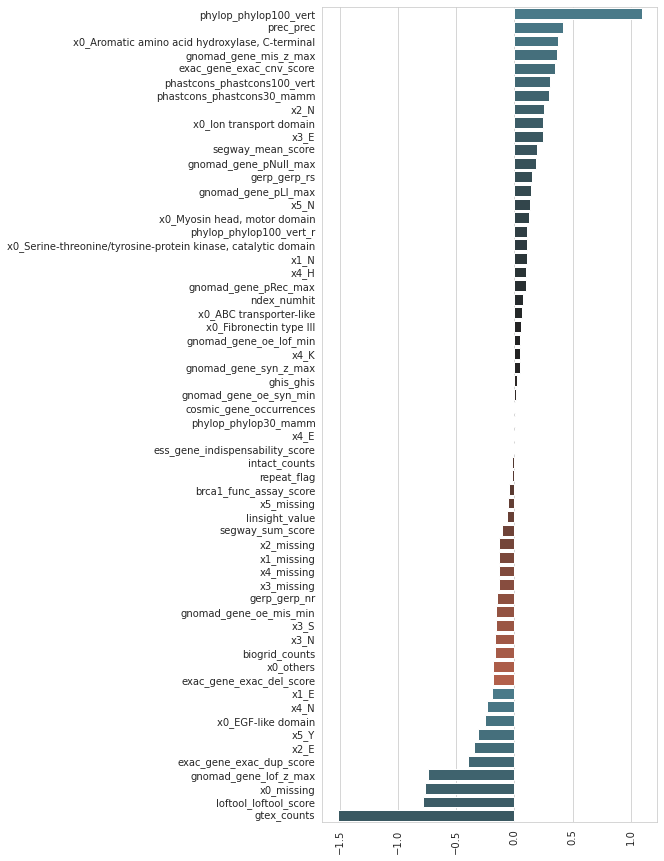

In [200]:
matplotlib.rcParams['figure.figsize'] = [6,15]
sns.set_style("whitegrid")
coefs = pd.Series(model['0.1']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

# Recursive Feature Elimination?

### Que tenemos?
* a la cabeza, conservación con approache filogenético --variant fetaure--
* Expresión diferencial (gtex) --gene fetaure-- 
* Loss of function --gene fetaure--?
* gnomad, loss of funcion z-score  --gene fetaure--
* Intepro domain (falta de)  --Protein fetaure--
* Inferencia recesive gene
* gnomad max O/E missense per gene. 

##### En menor medida:



###  Raro que  Non Essenctial categories salgan con coeficientes positivos. 
* raro biogrid también

# veamos otra relacion items vs columsn


In [5]:
X_subtrain, _, y_subtrain, _ = train_test_split(X_train, y_train, test_size=0.96, random_state=SEED,stratify = y_train)
X_subtrain.shape


(346, 39)

In [6]:
#lr_C =  [0.1,1,10]
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  
lr_C =  [0.00000001,0.0001,0.001,0.01,0.1,1,10,100,500,1000]


param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1'], 'clasificador__max_iter': [3000]}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'average_precision').fit(X_subtrain, y_subtrain[targetname].ravel())


#pipeline = search.best_estimator_  ## Nuestro pipeline se usó localmente. Con esta línea le paso la configuración óptima de la búsqueda

In [7]:
search.best_score_

0.7671481629590352

Text(0.5, 0, 'regularization parameter')

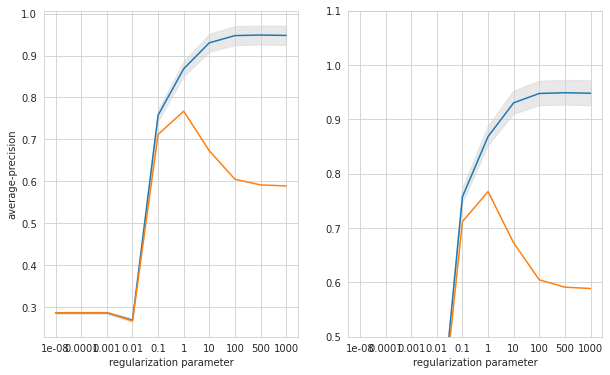

In [8]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('average-precision')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.5,1.1])

ax2.set_xlabel('regularization parameter')
